In [1]:
## TABULAR
import pandas as pd 
import numpy as np
import matplotlib

## GEO
import geopandas as gpd
import fiona
import folium
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
from folium.vector_layers import Circle, CircleMarker
from shapely.geometry import LineString, Point
from shapely import wkt


## DATA
import os
import zipfile
from collections import Counter
import re
from datetime import datetime
import requests
#from dotenv import load_dotenv, find_dotenv
import ast
import datetime as dt
from io import StringIO, BytesIO


## VIS
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa
import branca
import plotly.express as px

## TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima 


## MODELLING
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as rfr

## NEURAL NETWORKS
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
df_noise_2021 = pd.read_csv('data/noise_data/san_salvario_2021.csv', skiprows= [0,1,2,3,4,5,6,7], sep =';')
df_noise_2021

,Data,Ora,C1,C2,C3,C4,C5
0,01-01-2021,00:00,"67,2","62,3","64,6",NaN,NaN
1,01-01-2021,01:00,"48,9","44,4","47,8",NaN,NaN
2,01-01-2021,02:00,"44,9","40,8","44,1",NaN,NaN
3,01-01-2021,03:00,"42,0","39,2","41,7",NaN,NaN
4,01-01-2021,04:00,"41,9","40,7","44,7",NaN,NaN
...,...,...,...,...,...,...,...
4147,22-06-2021,19:00,"54,4","56,2","58,8",NaN,NaN
4148,22-06-2021,20:00,"54,7","53,9","58,0",NaN,NaN
4149,22-06-2021,21:00,"53,6","48,8","62,5",NaN,NaN
4150,22-06-2021,22:00,"54,5","55,6","63,9",NaN,NaN


In [3]:
df_noise_2021.drop(columns=['C4','C5'], inplace=True)

In [4]:
df_noise_2021['C3'].isna().sum()

45

In [5]:
df_noise_2021['date_hour'] = df_noise_2021['Data'] + ' ' + df_noise_2021['Ora']
df_noise_2021['date_hour'] = pd.to_datetime(df_noise_2021['date_hour'])
df_noise_2021.head(2)

,Data,Ora,C1,C2,C3,date_hour
0,01-01-2021,00:00,"67,2","62,3","64,6",2021-01-01 00:00:00
1,01-01-2021,01:00,"48,9","44,4","47,8",2021-01-01 01:00:00


In [6]:
#Typecasting the data
df_noise_2021['Ora']=pd.to_datetime(df_noise_2021['Ora']).dt.hour        #Changing the hour format
df_noise_2021['Data']=pd.to_datetime(df_noise_2021['Data'])     #Changing the date format
#Converting the noise readings into decimal format
df_noise_2021['C1']=df_noise_2021['C1'].apply(lambda x: str(x).replace(',','.'))
df_noise_2021['C2']=df_noise_2021['C2'].apply(lambda x: str(x).replace(',','.'))
df_noise_2021['C3']=df_noise_2021['C3'].apply(lambda x: str(x).replace(',','.'))

In [7]:
#Conerting the noise reading to float values
df_noise_2021['C1']=df_noise_2021['C1'].apply(lambda x: float(x))
df_noise_2021['C2']=df_noise_2021['C2'].apply(lambda x: float(x))
df_noise_2021['C3']=df_noise_2021['C3'].apply(lambda x: float(x))

In [8]:
#Adding day value like Monday as 0, Tuseday as 1 etc to the noise data based on date
df_noise_2021['day']=df_noise_2021['Data'].dt.dayofweek

In [9]:
#Fillig the null values considering means on hourly basis
df_noise_2021["C1"] = df_noise_2021.groupby(["Ora",'day'])['C1'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2021["C2"] = df_noise_2021.groupby(["Ora",'day'])['C2'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2021["C3"] = df_noise_2021.groupby(["Ora",'day'])['C3'].transform(lambda x: x.fillna(round(x.mean(),1)))

In [10]:
df_noise_2021['Log_Avg']=np.log10(((10**(df_noise_2021['C1']/10))+(10**(df_noise_2021['C2']/10))+(10**(df_noise_2021['C3']/10)))/5)*10
df_noise_2021

,Data,Ora,C1,C2,C3,date_hour,day,Log_Avg
0,2021-01-01,0,67.2,62.3,64.6,2021-01-01 00:00:00,4,62.935990
1,2021-01-01,1,48.9,44.4,47.8,2021-01-01 01:00:00,4,45.196258
2,2021-01-01,2,44.9,40.8,44.1,2021-01-01 02:00:00,4,41.375412
3,2021-01-01,3,42.0,39.2,41.7,2021-01-01 03:00:00,4,38.916228
4,2021-01-01,4,41.9,40.7,44.7,2021-01-01 04:00:00,4,40.549900
...,...,...,...,...,...,...,...,...
4147,2021-06-22,19,54.4,56.2,58.8,2021-06-22 19:00:00,1,54.626584
4148,2021-06-22,20,54.7,53.9,58.0,2021-06-22 20:00:00,1,53.697905
4149,2021-06-22,21,53.6,48.8,62.5,2021-06-22 21:00:00,1,56.197660
4150,2021-06-22,22,54.5,55.6,63.9,2021-06-22 22:00:00,1,57.923392


In [24]:
df_noise_2021['date'] = df_noise_2021['date_hour'].dt.date
df_noise_2021

,C1,C2,C3,date_hour,day,Log_Avg,date
0,67.2,62.3,64.6,2021-01-01 00:00:00,4,62.935990,2021-01-01
1,48.9,44.4,47.8,2021-01-01 01:00:00,4,45.196258,2021-01-01
2,44.9,40.8,44.1,2021-01-01 02:00:00,4,41.375412,2021-01-01
3,42.0,39.2,41.7,2021-01-01 03:00:00,4,38.916228,2021-01-01
4,41.9,40.7,44.7,2021-01-01 04:00:00,4,40.549900,2021-01-01
...,...,...,...,...,...,...,...
4147,54.4,56.2,58.8,2021-06-22 19:00:00,1,54.626584,2021-06-22
4148,54.7,53.9,58.0,2021-06-22 20:00:00,1,53.697905,2021-06-22
4149,53.6,48.8,62.5,2021-06-22 21:00:00,1,56.197660,2021-06-22
4150,54.5,55.6,63.9,2021-06-22 22:00:00,1,57.923392,2021-06-22


In [ ]:
df_noise_2021_daily = df_noise_2021['date'].

In [11]:
df_noise_2021_daily = df_noise_2021[['date_hour','Log_Avg']].groupby(df_noise_2021['date_hour'].dt.date).mean()

In [12]:
df_noise_2021_daily

,Log_Avg
date_hour,
2021-01-01,50.436783
2021-01-02,52.247973
2021-01-03,52.386967
2021-01-04,53.286838
2021-01-05,54.458272
...,...
2021-12-02,53.645544
2021-12-03,53.141915
2021-12-04,53.202073


In [13]:
df_noise_2021_daily = df_noise_2021[['Data','Log_Avg']].groupby(df_noise_2021['date_hour'].dt.date).mean()

In [14]:
df_noise_2021_daily.tail(10)

,Log_Avg
date_hour,
2021-11-03,53.151882
2021-11-04,53.996871
2021-11-05,55.354692
2021-11-06,56.540157
2021-12-01,52.604366
2021-12-02,53.645544
2021-12-03,53.141915
2021-12-04,53.202073
2021-12-05,56.292077


In [15]:
df_noise_2021['date_hour'].dt.date

0       2021-01-01
1       2021-01-01
2       2021-01-01
3       2021-01-01
4       2021-01-01
           ...    
4147    2021-06-22
4148    2021-06-22
4149    2021-06-22
4150    2021-06-22
4151    2021-06-22
Name: date_hour, Length: 4152, dtype: object

<AxesSubplot:xlabel='date_hour'>

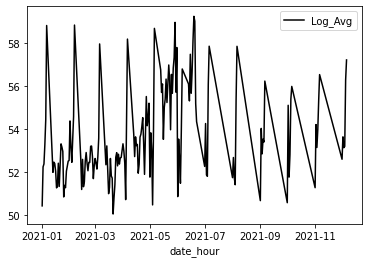

In [16]:
df_noise_2021_daily.plot(style = 'k')

In [17]:
df_noise_2021['Log_Avg'].isna().sum()

0

● November 6th until April 25th always closed;

○ April 26th - May 17th: only terraces open, curfew 10 P.M. - 5 A.M.;

○ May 18th - June 6th: curfew 11 P.M. - 5 A.M.;

○ June 7th - June 13th: curfew 0 A.M. - 5 A.M.;

○ June 14th - June 20th: indoor and terraces open, curfew 0 A.M. - 5 A.M.,

○ June 21st: no curfew, alcohol cannot be served after 3 AM (National
Security Act).

In [18]:
df_noise_2021.drop(columns = ['Data', 'Ora'], inplace= True)

In [19]:
df_noise_2021_daily.set_index('date_hour', inplace=True)

KeyError: "None of ['date_hour'] are in the columns"

In [ ]:
df_noise_2021['Log_Avg'].plot(style = 'k')